# Load the environment

In [203]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
# Common imports
import fitsio
import numpy as np
import os
import pandas as pd
import sys

In [205]:
# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=18)

In [206]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [207]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, objective, wave
from quasarnet.utils import process_preds, absorber_IGM

In [208]:
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph
    tf.random.set_seed(seed)
    np.random.seed(seed)

# For DESI

## Get DESI catalogue

In [4]:
def get_calum_data(calum_dir):
    file_matching = fitsio.FITS(calum_dir,vstorage='object')
    compare_information = pd.DataFrame({
    'tileID_desi': file_matching[1]['TILEID'][:].byteswap().newbyteorder(),
    'NIGHT_desi': file_matching[1]['NIGHT'][:].byteswap().newbyteorder(),    
    'thingid_desi': file_matching[1]['TARGETID'][:].byteswap().newbyteorder(),
    'mjd_desi':file_matching[1]['MJD'][:].byteswap().newbyteorder(),
    'fib_desi':file_matching[1]['FIBER'][:].byteswap().newbyteorder(),
    'z_desi':file_matching[1]['Z'][:].byteswap().newbyteorder()})
    return compare_information

In [105]:
desi_catalogue = get_calum_data('/global/u1/t/tanting/DESI_analysis/DESI_eboss_match/DESI_eboss_match_quasar.fits')[0:200]

In [174]:
desi_catalogue

,tileID_desi,NIGHT_desi,thingid_desi,mjd_desi,fib_desi,z_desi
0,80693,20210109,39633561183060922,59224.366280,1465,2.334592
1,80693,20210109,39633562823033395,59224.366280,4598,1.685592
2,80620,20201222,39633435047757147,59206.409566,1060,0.901745
3,80620,20201222,39633437681780838,59206.409566,1328,2.347548
4,80620,20201222,39633440286442550,59206.409566,1322,2.418898
...,...,...,...,...,...,...
195,68001,20200315,35191263049287474,58924.243849,1354,1.674370
196,68001,20200315,35191263057674549,58924.243849,780,3.151830
197,68000,20200314,35191263057674777,58923.253473,770,-0.001996
198,70006,20200305,35191263057675964,58914.480349,947,1.925483


In [225]:
import pdb
import fnmatch
from scipy.interpolate import splev, splrep

In [247]:
data_desi = {'tileID_desi':[], 'NIGHT_desi': [], 'thingid_desi': [], 'mjd_desi': [], 'fib_desi':[], 'z_desi':[], 'flux':[]}
date = []
fail_expoture = 0
release= 'daily'
dir_desi = '/global/cfs/cdirs/desi/spectro/redux/'+release+'/tiles'
for i,dir_tile,dir_night in zip(desi_catalogue.index,desi_catalogue.tileID_desi,desi_catalogue.NIGHT_desi):
    dir_total=dir_desi+'/'+str(dir_tile)+'/'+str(dir_night)
    file_total = []
    file_cframe = []
    # pdb.set_trace()
    try:
        for file in os.listdir(dir_total):
            if fnmatch.fnmatch(file, 'coadd*.fits'):
                file_total.append(dir_total+'/'+file)
            if fnmatch.fnmatch(file, 'cframe-b*.fits'):
                file_cframe.append(dir_total+'/'+file)
        for coadd_file in file_total:
            file = fitsio.FITS(coadd_file,vstorage='object')
            place = np.where(file['FIBERMAP']['TARGETID'][:]==desi_catalogue.thingid_desi[i])
            if place[0].any():
                if not desi_catalogue.thingid_desi[i] in data_desi['thingid_desi']:
                    order = int(place[0][0])
                    if desi_catalogue.fib_desi[i]==file['FIBERMAP']['FIBER'][:][order]:
                        try:
                            if desi_catalogue.z_desi[i] > 2.1:
                                flux = file['BRZ_FLUX'][order,:][0]
                                ivar = file['BRZ_IVAR'][order,:][0]
                                # wavelength = file['BRZ_WAVELENGTH'][:]
                                flux_nor = flux * np.sqrt(ivar) - np.mean(flux)
                                # flux_func = splrep(wavelength, flux_nor)
                                flux_final = flux_nor[:443]
                                data_desi['flux'].append(np.transpose(flux_final.tolist()))
                                data_desi['tileID_desi'].append(desi_catalogue.tileID_desi[i])
                                data_desi['NIGHT_desi'].append(desi_catalogue.NIGHT_desi[i])
                                data_desi['thingid_desi'].append(desi_catalogue.thingid_desi[i])
                                data_desi['mjd_desi'].append(desi_catalogue.mjd_desi[i])
                                data_desi['fib_desi'].append(desi_catalogue.fib_desi[i])
                                data_desi['z_desi'].append(desi_catalogue.z_desi[i])
                                # len 7781
                        except:
                            continue
                            # flux = np.hstack((file['B_FLUX'][order,:][0],file['R_FLUX'][order,:][0],file['Z_FLUX'][order,:][0]))
                            # len 7958
                        
    except:
        # print('Wrong directory')
        continue
print('finish searching for {} targets, with {} targets found'.format(desi_catalogue.index[-1]+1,len(data_desi['flux'])))


finish searching for 200 targets, with 21 targets found


In [135]:
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_68002.fits',vstorage='object')
DESI_quasar[1]


  file: /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_68002.fits
  extension: 1
  type: BINARY_TBL
  rows: 917
  column info:
    THING_ID            i8  
    Z_VI                f8  
    PLATE               S8  
    MJD                 i4  
    FIBERID             i4  
    CLASS_PERSON        f8  
    BAL_FLAG_VI         f8  
    BI_CIV              f8  
    Z_CONF_PERSON       i8  

In [231]:
from astropy.io import fits
from astropy.io.fits import Column
len_data = len(data_desi['thingid_desi'])
a1 = Column(name='THING_ID', format='1K', array=data_desi['thingid_desi'])
a2 = Column(name='Z_VI', format='1D', array=data_desi['z_desi'])
a3 = Column(name='MJD', format='1D', array=data_desi['mjd_desi'])
a4 = Column(name='FIBERID', format='1K', array=data_desi['fib_desi'])
a5 = Column(name='tileID', format='1K', array=data_desi['tileID_desi'])
a6 = Column(name='NIGHT', format='1K', array=data_desi['NIGHT_desi'])
data = np.array(data_desi['flux']).reshape(len(data_desi['flux']),-1)
hdr = fits.Header()
primary_hdu = fits.PrimaryHDU(data,header=hdr)
hdu = fits.BinTableHDU.from_columns([a1, a2, a3, a4, a5, a6])
thdulist = fits.HDUList([primary_hdu,hdu])
thdulist.writeto('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',overwrite=True)

In [155]:
test = fitsio.FITS('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',vstorage='object')


numpy.ndarray

In [147]:
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_68002.fits',vstorage='object')
DESI_quasar[0]


  file: /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_68002.fits
  extension: 0
  type: IMAGE_HDU
  image info:
    data type: u1
    dims: []

In [146]:
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits',vstorage='object')
DESI_quasar[0]


  file: /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits
  extension: 0
  type: IMAGE_HDU
  image info:
    data type: f8
    dims: [1275,868]

In [156]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
loss = [custom_loss]*(len(lines))

In [234]:
desi_quasar_data = fitsio.FITS('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',vstorage='object')
desi_quasar_data[1]


  file: /global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits
  extension: 1
  type: BINARY_TBL
  rows: 154
  column info:
    THING_ID            i8  
    Z_VI                f8  
    MJD                 f8  
    FIBERID             i8  
    tileID              i8  
    NIGHT               i8  

In [235]:
X_desi = desi_quasar_data[0][:,:]
Y_desi = np.array([desi_quasar_data[1]['tileID'][:],desi_quasar_data[1]['NIGHT'][:],desi_quasar_data[1]['THING_ID'][:],desi_quasar_data[1]['MJD'][:],desi_quasar_data[1]['FIBERID'][:]])
z_desi = desi_quasar_data[1]['Z_VI'][:]

In [211]:
ntrain = 100
nepochs = 5

In [201]:
model = QuasarNET((X_train.shape[1],1), nlines=len(lines))

In [209]:
model.compile(optimizer=Adam(), loss=loss, metrics=[])

In [212]:
target, sample_weight = objective(z_train[:ntrain],Y_train[:ntrain],lines=lines)
loss_history = model.fit(X_train[:ntrain,:,None], target, epochs=nepochs, batch_size=32, sample_weight=sample_weight)

TypeError: objective() missing 1 required positional argument: 'bal'

In [236]:
X_desi.shape

(154, 443)

In [226]:
X_val.shape

(2412, 443)

In [246]:
Y_val

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

No handles with labels found to put in legend.


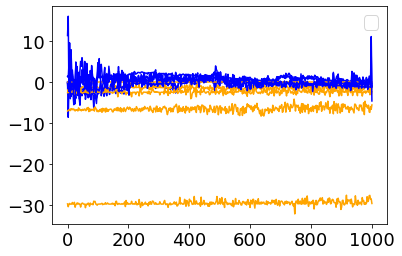

In [237]:
plt.figure()
wave_desi = np.linspace(0,1000,len(X_desi[0]))
wave_val = np.linspace(0,1000,len(X_val[0]))
for num in range(5):
    plt.plot(wave_desi,X_desi[num],color = 'orange')
    plt.plot(wave_val,X_val[num],color = 'blue')

plt.legend()
plt.show()

In [213]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal = ['CIV(1548)']
loss = [custom_loss]*(len(lines)+len(lines_bal))
nspec = 30000
truth_file=(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits'], truth, nspec=nspec)

# Load the training data.
data_file = '/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_train_0.fits'
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

# To get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]
ntrain = 10000
nepochs = 5
model = QuasarNET((X_train.shape[1],1), nlines=len(lines)+len(lines_bal))
model.compile(optimizer=Adam(), loss=loss, metrics=[])

target, sample_weight = objective(z_train[:ntrain],Y_train[:ntrain],bal_train[:ntrain],lines=lines,lines_bal=lines_bal)
loss_history = model.fit(X_train[:ntrain,:,None], target, epochs=nepochs, batch_size=32, sample_weight=sample_weight)

INFO: reading data from /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 82 spectra missing in truth
INFO: found (29786,) spectra in file /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 40 spectra with zero weights
INFO: removing 0 spectra with zero flux
Epoch 1/5
313/313 [==============================] - 9s 30ms/step - loss: 1.2095 - conc_box_0_loss: 0.1768 - conc_box_1_loss: 0.2029 - conc_box_2_loss: 0.2253 - conc_box_3_loss: 0.2081 - conc_box_4_loss: 0.1540 - conc_box_5_loss: 0.0889 - conc_box_6_loss: 0.1535
Epoch 2/5
313/313 [==============================] - 8s 26ms/step - loss: 0.2689 - conc_box_0_loss: 0.0382 - conc_box_1_loss: 0.0472 - conc_box_2_loss: 0.0581 - conc_box_3_loss: 0.0554 - conc_box_4_loss: 0.0240 - conc_box_5_loss: 0.0088 - conc_box_6_loss: 0.0372
Epoch 3/5
313/313 [==============================] - 8s 27ms/step - loss: 0.1517 - conc_box_0_loss: 0.0229 - conc_box_1_loss: 0.

In [238]:
p = model.predict(X_desi[:,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)

INFO: nspec = 154, nboxes=13


In [239]:
ndetect = 1
c_th = 0.5

In [240]:
def plot_spectrum(ival,X,c_line,z_line,zbest,Y,z,c_th=0.5,ndetect=1):
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(wave, X[ival,:])
    
    isqso_truth = (Y[ival,:].argmax()==2) | (Y[ival,:].argmax()==3)
    isqso_qn = (c_line[:,ival].sum()>c_th)>=ndetect
    
    title = r'Is QSO? VI: {}, QN: {}'.format(isqso_truth,isqso_qn)
    title += '\n'
    title += r'$z_{{VI}}$={:1.3f}, $z_{{QN}}$='.format(z[ival])
    if isqso_qn:
        title += r'{:1.3f}'.format(zbest[ival])
    else:
        title += 'N/A'
    
    ax.set_title(title)
    m = X[ival,:].min()
    M = X[ival,:].max()
    ax.grid()
    ax.set_ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il,ival])
        w = abs(wave-lam)<100
        if w.sum()>0:
            m = X[ival,w].min()-1
            M = X[ival,w].max()+1
            ax.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il,ival])
            ax.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,ival],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line[il,ival])
    ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
    ax.set_ylabel(r'renormalised flux')
    plt.show()
    
    return

IndexError: index 10 is out of bounds for axis 0 with size 5

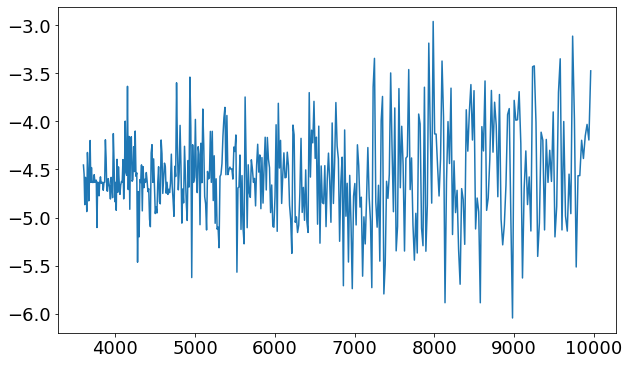

In [243]:
plot_spectrum(10,X_desi,c_line,z_line,zbest,Y_desi,z_desi,c_th=c_th,ndetect=ndetect)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

# Set up our arrays.
c_th = np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (Y_val.argmax(axis=1)==2) | (Y_val.argmax(axis=1)==3)
is_bad = Y_val.argmax(axis=1)==4

# Determine which spectra QN accurately estimated the redshift for
zgood = (z_val>0) & (abs(zbest-z_val) < dv_max*(1+z_val))

# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_th):
    isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood & ~is_bad).sum()
    pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax.plot(c_th, pur, label='Purity')
ax.plot(c_th, com, label='Completeness')
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.8,1.0)
ax.set_xlabel(r'$c_{th}$')
ax.grid()
ax.legend()